# Tokar & Gary 1984

In [1]:
import numpy as np
import scipy.optimize
from py_vlasov.util import zp, kzkp, list_to_complex, real_imag, nullspace
from py_vlasov.wrapper import oblique_wrapper, disp_det, input_gen
from py_vlasov.transport_ratios import transport_ratios
from py_vlasov.follow_parameter import follow_k
from py_vlasov.dispersion_tensor import f_d

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['axes.labelsize'] = 16
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14

%matplotlib inline

In [2]:
def fast_freq(k, theta, betap):
    kz, kp = kzkp(k, theta)
    cos_theta = kz / k
    kdi = k / np.sqrt(betap)
    return kdi * np.sqrt(1 + kdi**2 * cos_theta**2)

def ea_freq(k, theta, aol, the_tp, nc_nh):
    kz, kp = kzkp(k, theta)
    mp_me = 1836
    num = kz * np.sqrt(0.5 * nc_nh/(1+nc_nh) * the_tp * mp_me)
    k_rhose_2 = kp**2 * 0.5 * nc_nh * the_tp / mp_me
    kp_debye_2 = (kz**2+kp**2) * 0.5 * aol**2 * the_tp
    denom = np.sqrt(1 + k_rhose_2 + kp_debye_2)
    print(denom)
    return num / denom

def kdi_2_krhoi(kdi, betap):
    return kdi * np.sqrt(betap)

$$\omega_{pe} = \Omega_e \Rightarrow \frac{v_A^2}{c^2} = \frac{1}{1836}$$

$$\beta_p = 10^{-4}$$

$$T_h/T_c=10^3$$
$$n_h = n_c$$
$$T_h/T_p = 10$$

In [3]:
tc_th = 1e-3
the_tp = 10
aol = np.sqrt(1/1836)
print('aol = ', aol)
betap = 1e-4
theta = 0.1

t_list=[1., the_tp, the_tp * tc_th]
a_list=[1., 1., 1.]
n_list=[1.,.5,.5] 
q_list=[1.,-1., -1.]
m_list=[1., 1./1836., 1./1836]
v_list=[0.,0.,0.]
n = 10
method = 'pade'

kdi = 10

# target_kde = 1
# target_kdi = target_kde * np.sqrt(1836)
target_kdi = 1000 * np.sqrt(2)

k = kdi_2_krhoi(kdi, betap)
kz, kp = kzkp(k, theta)
print(k, kz, kp)

param = [kz, kp, betap, t_list, a_list, n_list, q_list,
         m_list, v_list, n, method, aol]

aol =  0.0233380014005
0.1 0.0999998476913 0.00017453283659


In [4]:
target_k = kdi_2_krhoi(target_kdi, betap)
print('target_k = {0:.2f}'.format(target_k))
print('target_kde = {0:.3g}'.format(target_kdi / np.sqrt(1836.)))

# seed_freq = fast_freq(k, theta, betap)
seed_freq = ea_freq(k, theta, aol, the_tp, nc_nh=n_list[2]/n_list[1])
f = lambda wrel:\
    real_imag(oblique_wrapper(list_to_complex(wrel), kz, kp, betap,
                              t_list, a_list, n_list, q_list, \
                              m_list, v_list, method = method, n = n, \
                              aol=aol))
guess = seed_freq * (1-.6j)
print('seed_freq = {0:.3g}'.format(guess))

wr, wi = scipy.optimize.fsolve(f, real_imag(guess))

print(wr)
print(wi)
print(wr/1836/np.cos(np.deg2rad(theta)))
freq = follow_k(guess, target_k, param,
                log_incrmt = 0.02, incrmt_method = 'log')

target_k = 14.14
target_kde = 33
1.00001361651
seed_freq = 6.77-4.06j
6.85437078182
-3.80332779102
0.00373332310547


In [5]:
freq_arr = np.array(freq[-1])
print(freq_arr[::5])

[   6.85437078  -3.80332779j    7.56795451  -4.19924793j
    8.35582946  -4.63637677j    9.22573101  -5.11900138j
   10.18620024  -5.65185415j   11.24666805  -6.24015873j
   12.41754789  -6.88968076j   13.71033844  -7.60678362j
   15.13773689  -8.39848982j   16.71376423  -9.27254844j
   18.45390378 -10.23750923j   20.37525430 -11.30280387j
   22.49669942 -12.47883496j   24.83909510 -13.77707329j
   27.42547721 -15.21016395j   30.28129145 -16.79204168j
   33.43464824 -18.53805586j   36.91660558 -20.46510527j
   40.76148316 -22.59178258j   45.00721168 -24.93852798j
   49.69572187 -27.52779093j   54.87337851 -30.3841981j
   60.59146556 -33.53472431j   66.90672976 -37.00886194j
   73.88199145 -40.83878145j   81.58683305 -45.05947307j
   90.09837782 -49.70885473j   99.50217425 -54.82782546j
  109.89320459 -60.46023485j  121.37704012 -66.65272701j
  134.07117035 -73.45440127j  148.10653830 -80.91620787j
  163.62931971 -89.08996468j  180.80298774 -98.02683395j
  199.81070577-107.7750321j   22

In [6]:
# kde_start = kdi / np.sqrt(1836)
# kde_end = np.sqrt(freq[1][0]**2 + freq[1][1]**2) /np.sqrt(1836) / np.sqrt(betap)
# kde_list = np.logspace(np.log10(kde_start), np.log10(kde_end), len(freq_arr))

krhoi_list = np.logspace(np.log10(k), np.log10(target_k), len(freq_arr))/np.sqrt(2)

In [7]:
# np.save('data/ea_gary_krhoi', krhoi_list)
# np.save('data/ea_gary_freq_theta_01', freq_arr/1836)

In [8]:
nc_nh = n_list[2] / n_list[1]
freq_ea_theory = krhoi_list * np.cos(np.deg2rad(theta)) * np.sqrt(1836 * the_tp * (nc_nh/(1+nc_nh)))

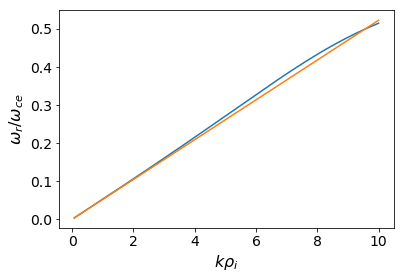

In [9]:
plt.plot(krhoi_list, freq_arr.real/1836)
plt.plot(krhoi_list, freq_ea_theory/1836)
plt.xlabel(r'$k\rho_i$')
plt.ylabel(r'$\omega_r/\omega_{ce}$')
# plt.xlim([0.1, 2])
# plt.ylim([0,.1])
# plt.yscale('log')
# plt.xscale('log')

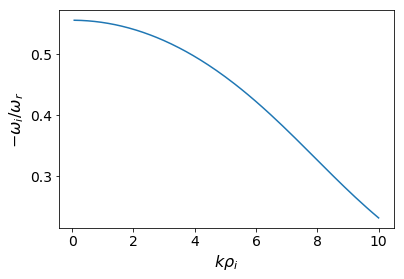

In [10]:
plt.plot(krhoi_list, -freq_arr.imag/freq_arr.real)
plt.xlabel(r'$k\rho_i$')
plt.ylabel(r'$-\omega_i/\omega_r$')
# plt.ylim([0,.1])
# plt.yscale('log')
# plt.xscale('log')

In [25]:
krhoi_list = np.load('data/ea_gary_krhoi.npy')
freq_arr_01 = np.load('data/ea_gary_freq_theta_01.npy')
freq_arr_30 = np.load('data/ea_gary_freq_theta_30.npy')
freq_arr_60 = np.load('data/ea_gary_freq_theta_60.npy')

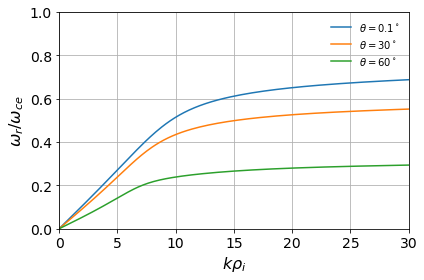

In [26]:
plt.plot(krhoi_list, freq_arr_01.real, label = r'$\theta=0.1^\circ$')
plt.plot(krhoi_list, freq_arr_30.real, label = r'$\theta=30^\circ$')
plt.plot(krhoi_list, freq_arr_60.real, label = r'$\theta=60^\circ$')

plt.xlabel(r'$k\rho_i$')
plt.ylabel(r'$\omega_r/\omega_{ce}$')
plt.ylim([0, 1])
plt.xlim([0, 30])
plt.tight_layout()
plt.grid()
plt.legend(frameon = False)
# plt.savefig('figure/ea_gary_dispersion_real.png')

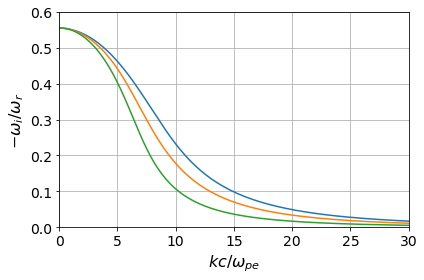

In [27]:
# plt.plot(kde_list, freq_arr.imag/1836/np.cos(np.deg2rad(theta)))
plt.plot(krhoi_list, -freq_arr_01.imag/freq_arr_01.real, label = r'$\theta=0.1^\circ$')
plt.plot(krhoi_list, -freq_arr_30.imag/freq_arr_30.real, label = r'$\theta=30^\circ$')
plt.plot(krhoi_list, -freq_arr_60.imag/freq_arr_60.real, label = r'$\theta=60^\circ$')
plt.xlabel('$kc/\omega_{pe}$')
plt.ylabel(r'$-\omega_i/\omega_r $')
plt.ylim([0, .6])
plt.xlim([0, 30])
plt.grid()
plt.tight_layout()
# plt.savefig('figure/ea_gary_dispersion_imag_1.png')

In [11]:
k_end = np.sqrt(freq[1][0]**2 + freq[1][1]**2)
k_start = kdi_2_krhoi(kdi, betap)
k_list = np.logspace(np.log10(k_start), np.log10(k_end), len(freq_arr))

ex_ez_list = []
ey_ez_list = []
by_bx_list = []

for i in range(len(k_list)):
    freq_i = freq_arr[i]
    kz, kp = kzkp(k_list[i], theta)
#     inp = input_gen(freq_i, kp, kz, betap)
    inp = input_gen(freq_i, kz, kp, betap, t_list, \
              a_list, n_list, q_list, m_list, v_list, \
              n, method = method, aol=aol)
    tr = transport_ratios(inp, print_result = False)
    eigen_e = tr['eigen_e']
    kvec = np.array([kp, 0, kz])
    khat = kvec/np.linalg.norm(kvec)
    ez_prime = np.dot(eigen_e, khat) * khat
    ey_prime = np.array([0, eigen_e[1], 0])
    ex_prime = eigen_e - ez_prime - ey_prime
    ex_ez = np.linalg.norm(ex_prime) / np.linalg.norm(ez_prime)
    ey_ez = np.linalg.norm(ey_prime) / np.linalg.norm(ez_prime)
    ex_ez_list.append(ex_ez)
    ey_ez_list.append(ey_ez)
    
    eigen_b = np.cross(kvec, eigen_e)
    bz_prime = np.dot(eigen_b, khat) * khat
    by_prime = np.array([0, eigen_b[1], 0])
    bx_prime = eigen_b - bz_prime - by_prime
    by_bx = np.linalg.norm(bx_prime) / np.linalg.norm(by_prime)
    by_bx_list.append(by_bx)

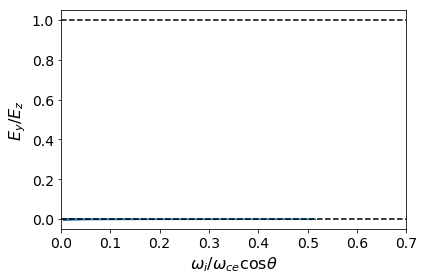

In [13]:
plt.plot(freq_arr.real/1836/np.cos(np.deg2rad(theta)), ex_ez_list, '.-', markersize = 1)
plt.xlabel(r'$\omega_i/\omega_{ce} \cos \theta $')
plt.ylabel('$E_y/E_z$')
plt.axhline(1, linestyle='dashed', color='k')
plt.axhline(0, linestyle='dashed', color='k')
# plt.ylim([-4, 4])
plt.xlim([0, 0.7])
plt.tight_layout()
# plt.savefig('ea_eyez_1.png')

In [15]:
def get_eigen_e(d):
    det_22 = d[1,1]*d[2,2] - d[1,2]*d[2,1]
    num_1 = -d[2,2]*d[1,0] + d[1,2]*d[2,0]
    num_2 = d[2,1]*d[1,0] - d[1,1]*d[2,0]
    return np.array([1, num_1/det_22, num_2/det_22])

def get_transport_ratios(k_list, freq_arr):
    ex_ez_list = []
    ey_ez_list = []
    by_bx_list = []
    
    eigen_e_list = []
    eigen_b_list = []
    dt_list = []

    for i in range(len(k_list)):
        freq_i = freq_arr[i]
        kz, kp = kzkp(k_list[i], theta)
#         inp = input_gen(freq_i, kp, kz, betap)
        inp = input_gen(freq_i, kz, kp, betap, t_list, \
              a_list, n_list, q_list, m_list, v_list, \
              n, method = method, aol=aol)
        
    
        # reshape the parameters to calculate dispersion tensor
        param = list(map(list, zip(*inp)))
        # dispersion tensor
        dt = f_d(param)
        dt_list.append(dt)
        
        tr = transport_ratios(inp, print_result = False)
        eigen_e = tr['eigen_e']
#         eigen_e = get_eigen_e(dt)
        kvec = np.array([kp, 0, kz])
        khat = kvec/np.linalg.norm(kvec)
        ez_prime = np.dot(eigen_e, khat) * khat
        ey_prime = np.array([0, eigen_e[1], 0])
        ex_prime = eigen_e - ez_prime - ey_prime
        ex_ez = np.linalg.norm(ex_prime) / np.linalg.norm(ez_prime)
        ey_ez = np.linalg.norm(ey_prime) / np.linalg.norm(ez_prime)
        ex_ez_list.append(ex_ez)
        ey_ez_list.append(ey_ez)
        
        eigen_e_list.append(eigen_e)

        eigen_b = np.cross(kvec, eigen_e)
        bz_prime = np.dot(eigen_b, khat) * khat
        by_prime = np.array([0, eigen_b[1], 0])
        bx_prime = eigen_b - bz_prime - by_prime
        by_bx = np.linalg.norm(bx_prime) / np.linalg.norm(by_prime)
        by_bx_list.append(by_bx)
        
        eigen_b_list.append(eigen_b)
    return {'exez': ex_ez_list, 'eyez': ey_ez_list, 'bybx': by_bx_list, 'eigen_e':eigen_e_list, 'eigen_b':eigen_b_list, 'dt': dt_list}

In [16]:
k_end = np.sqrt(freq[1][0]**2 + freq[1][1]**2)
k_start = kdi_2_krhoi(kdi, betap)
k_list = np.logspace(np.log10(k_start), np.log10(k_end), len(freq_arr))

In [17]:
ea_tr = get_transport_ratios(k_list, freq_arr)

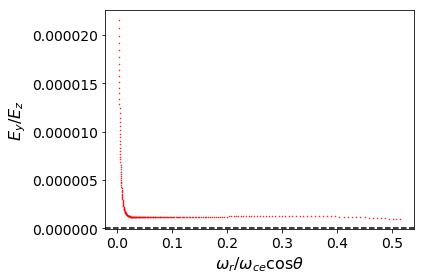

In [18]:
plt.plot(freq_arr.real/1836/np.cos(np.deg2rad(theta)), ea_tr['exez'], '.r', markersize = 1, label='electron acoustic')
plt.xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylabel('$E_y/E_z$')
plt.axhline(0, linestyle='dashed', color='k')
# plt.ylim([-1, 6])
# plt.xlim([0, 1])
plt.tight_layout()
# plt.savefig('whistler_ea_eyez_1.png')

# Study the if proper eigen vectors are returned

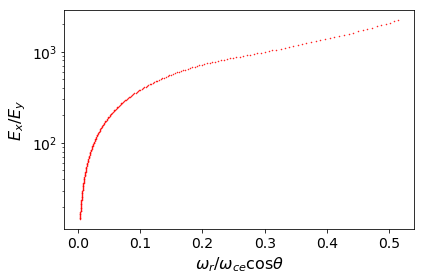

In [19]:
plt.plot(freq_arr.real/1836/np.cos(np.deg2rad(theta)), list(map(lambda x: abs(x[0]/x[1]), ea_tr['eigen_e'])), '.r', markersize = 1, label='electron acoustic')
plt.xlabel(r'$\omega_r/\omega_{ce} \cos \theta $')
plt.ylabel('$E_x/E_y$')
plt.axhline(0, linestyle='dashed', color='k')
# plt.ylim([-1, 6])
# plt.xlim([0, 1])
plt.yscale('log')
plt.tight_layout()
# plt.savefig('whistler_ea_eyez_1.png')

In [20]:
M = ea_tr['dt'][0]
print(M)

[[ -1.70099231e+05 -1.19473635e+02j  -6.29958240e+03 -1.17351185e+04j
    2.94018092e+02 -4.17950789e-04j]
 [  6.29958240e+03 +1.17351185e+04j  -1.70099744e+05 -1.19473307e+02j
    8.43120663e+00 -1.50584450e+01j]
 [  2.94018092e+02 -4.17950789e-04j  -8.43120663e+00 +1.50584450e+01j
   -5.06161738e-01 +1.53128021e-03j]]


In [21]:
v = nullspace(M*1e-20)
print(v/v[0])
print(ea_tr['eigen_e'][0])

[  1.00000000e+00+0.j           6.60610530e-02+0.01783487j
   5.79236777e+02+3.42598716j]
[   -3.80912268 -1.41091425e+01j     0.00000000 -1.00000000e+00j
 -2158.04620287 -8.18558424e+03j]


In [22]:
u, s, vh = np.linalg.svd(M*1e-20)

In [23]:
s

array([  1.81939861e-15,   1.58494654e-15,   5.43132012e-26])

In [24]:
vh

array([[  7.07105654e-01 +0.00000000e+00j,
         -1.35052337e-07 +7.07106888e-01j,
         -1.19941706e-03 -7.35502948e-05j],
       [ -7.07105801e-01 +0.00000000e+00j,
          1.43388151e-07 +7.07106665e-01j,
          1.24200589e-03 -8.79904585e-05j],
       [  1.72637693e-03 +0.00000000e+00j,
          1.14046278e-04 -3.07896999e-05j,
          9.99981012e-01 -5.91454521e-03j]])

In [27]:
np.linalg.det(ea_tr['dt'][10])

(489980.55932010605+125083.44683526622j)

In [102]:
get_eigen_e(M)

array([  1.00000000e+00 +0.00000000e+00j,
         3.70567664e-02 +6.89611899e-02j,   6.27235443e-07 -9.72202511e-07j])